In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso , LogisticRegression ,ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from yellowbrick.regressor import PredictionError, ResidualsPlot
import random

In [2]:
def get_fullpath (dir) :
  fullpath = []
  filename = os.listdir(dir)
  filename = sorted(filename)
  for i in filename :
    fullname = os.path.join(dir , i)
    fullpath.append(fullname)
  return (fullpath)

In [3]:
def get_dataset (file_pvalue ,file0 , file1) :
  df_pvalue = pd.read_excel(file_pvalue , index_col = 0)
  feature_list = []
  for i in df_pvalue.index :
    if df_pvalue.at[i,'p_value'] < 0.04 :
        feature_list.append(i)
  df0 = pd.read_excel (file0 , index_col = 1)
  df1 = pd.read_excel (file1 , index_col = 1)
  list_data0 = []
  list_data1 = []
  for i in df0.columns[1:] :
    data0 = []
    for f in df0.index :
      if f in feature_list :
        data0.append(df0.at[f,i])
    list_data0.append(data0)
  for i in df1.columns[1:] :
    data1 = []
    for f in df1.index :
      if f in feature_list :
        data1.append(df1.at[f,i])
    list_data1.append(data1)
  data0_label = [[0] for _ in range(len(list_data0))]
  data1_label = [[1] for _ in range(len(list_data1))]
  x = np.vstack((list_data0 , list_data1))
  y = np.vstack((data0_label , data1_label))
  return (x,y)

In [4]:
def Lasso_plus_Randomforest_test (x,y ,times = 100 , test_radio = 0.2) :
  y = y.ravel()
  features_selected_acc = []
  mask = []
  for i in range(100) :
    x_train , x_test  , y_train , y_test = train_test_split(x,y,
                        test_size = test_radio)
    select_feature = SelectFromModel(estimator=Lasso(alpha=1e-5,max_iter=1e4))
    select_feature.fit(x_train,y_train)
    if len(select_feature.get_support(True)) >= 1 :
      x_train_new = select_feature.transform(x_train)
      x_test_new = select_feature.transform(x_test)
      mask.append(select_feature.get_support())
      clf = RandomForestClassifier()
      clf.fit(x_train_new , y_train)
      acc = clf.score(x_test_new,y_test)
      features_selected_acc.append(acc)
    random.Random(i).shuffle(x)
    random.Random(i).shuffle(y)
  acc_max = max(features_selected_acc)
  index_for_best = features_selected_acc.index(acc_max)
  x_new = x[:,mask[index_for_best]]
  result = []
  confusion_matrix_list = []
  num = 0
  random_num = 0
  while num < times :
    x_train , x_test  , y_train , y_test = train_test_split(x_new,y,
                        test_size = test_radio)
    clf.fit(x_train, y_train)
    accuracy = clf.score(x_test , y_test)
    result.append(accuracy)
    y_pred = clf.predict(x_test)
    matrix = confusion_matrix(y_test , y_pred).ravel()
    confusion_matrix_list.append(matrix)
    num +=1
    random_num += 1
    random.Random(num).shuffle(x_new)
    random.Random(num).shuffle(y)
  return (result ,features_selected_acc , confusion_matrix_list , mask )

In [5]:
def Lasso_plus_Randomforest_test_v2 (x,y ,times = 100 , test_radio = 0.2) :
  y = y.ravel()
  features_selected_acc = []
  vector_list = []
  mask = []
  for i in range(100) :
    x_train , x_test  , y_train , y_test = train_test_split(x,y,
                        test_size = test_radio)
    lasso = Lasso(alpha=0.1)
    lasso.fit(x_train,y_train)
    vector = lasso.coef_
    vector_list.append(vector)
    feature_list = []
    for index,value in enumerate(vector) :
      if value != 0 :
        feature_list.append(index)
    mask.append(feature_list)
    if len(feature_list) >=1 :
      x_train_new = x_train[:,feature_list]
      x_test_new = x_test[:,feature_list]
      clf = RandomForestClassifier()
      clf.fit(x_train_new,y_train)
      acc = clf.score(x_test_new,y_test)
      features_selected_acc.append(acc)
    random.Random(i).shuffle(x)
    random.Random(i).shuffle(y)
  acc_max = max(features_selected_acc)
  index_for_best = features_selected_acc.index(acc_max)
  x_new = x[:,mask[index_for_best]]
  result = []
  confusion_matrix_list = []
  num = 0
  random_num = 0
  while num < times :
    x_train , x_test  , y_train , y_test = train_test_split(x_new,y,
                        test_size = test_radio)
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    accuracy = clf.score(x_test , y_test)
    result.append(accuracy)
    y_pred = clf.predict(x_test)
    matrix = confusion_matrix(y_test , y_pred).ravel()
    confusion_matrix_list.append(matrix)
    num +=1
    random_num += 1
    random.Random(num).shuffle(x_new)
    random.Random(num).shuffle(y)
  return (result ,features_selected_acc, confusion_matrix_list , mask , vector_list)

In [6]:
def Elastic_plus_Randomforest_test (x,y ,times = 100 , test_radio = 0.2) :
  y = y.ravel()
  features_selected_acc = []
  mask = []
  for i in range(100) :
    x_train , x_test  , y_train , y_test = train_test_split(x,y,
                        test_size = test_radio)
    select_feature = SelectFromModel(estimator=ElasticNet(alpha=.1,max_iter=1e4,copy_X = True),threshold=1e-5)
    select_feature.fit(x_train,y_train)
    if len(select_feature.get_support(True)) >= 1 :
      x_train_new = select_feature.transform(x_train)
      x_test_new = select_feature.transform(x_test)
      mask.append(select_feature.get_support(True))
      clf = RandomForestClassifier()
      clf.fit(x_train_new , y_train)
      acc = clf.score(x_test_new,y_test)
      features_selected_acc.append(acc)
    random.Random(i).shuffle(x)
    random.Random(i).shuffle(y)
  acc_max = max(features_selected_acc)
  index_for_best = features_selected_acc.index(acc_max)
  x_new = x[:,mask[index_for_best]]
  result = []
  confusion_matrix_list = []
  num = 0
  random_num = 0
  while num < times :
    x_train , x_test  , y_train , y_test = train_test_split(x_new,y,
                        test_size = test_radio)
    clf.fit(x_train, y_train)
    accuracy = clf.score(x_test , y_test)
    result.append(accuracy)
    y_pred = clf.predict(x_test)
    matrix = confusion_matrix(y_test , y_pred).ravel()
    confusion_matrix_list.append(matrix)
    num +=1
    random_num += 1
    random.Random(num).shuffle(x_new)
    random.Random(num).shuffle(y)
  return (result ,features_selected_acc , confusion_matrix_list , mask )

In [7]:
dir_pvalue = r'/content/drive/Shareddrives/食道癌/file_arranged_for_pvalue/pvalue_of_1year'
dir_0 = r'/content/drive/Shareddrives/食道癌/file_arranged_for_pvalue/less1year'
dir_1 = r'/content/drive/Shareddrives/食道癌/file_arranged_for_pvalue/more1year'
file_pvalue = get_fullpath(dir_pvalue)
file_0 = get_fullpath(dir_0)
file_1 = get_fullpath(dir_1)

In [8]:
result_final = []
for i in range(8) :
  x , y = get_dataset(file_pvalue[i],file_0[i],file_1[i])
  result ,features_selected_acc , confusion_matrix_list , mask = Lasso_plus_Randomforest_test(x,y)
  print(len(result))
  print(len(features_selected_acc))
  result_avg = sum(result)/len(result)
  result_final.append(result_avg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e-01, tolerance: 3.443e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.025e+00, tolerance: 3.438e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

100
8


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+00, tolerance: 3.414e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.813e+00, tolerance: 3.447e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

KeyboardInterrupt: ignored

In [ ]:
print(sum(result)/len(result))
print(mask[0].shape)
print(result_final)

In [9]:
x , y = get_dataset(file_pvalue[0],file_0[0],file_1[0])

In [10]:
x = np.array(x)
print(x.shape)

(173, 285)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+01, tolerance: 3.443e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


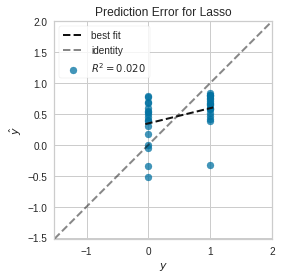

In [13]:
#test_lasso
model1 = Lasso()
x_train , x_test  , y_train , y_test = train_test_split(x,y,
                          test_size = 0.2)
visualizer = PredictionError(model1)
visualizer.fit(x_train, y_train) 
visualizer.score(x_test, y_test) 
visualizer.poof()

In [ ]:
result , confusion_matrix_list , mask  = Lasso_plus_Randomforest_test(x,y,times=10)

In [ ]:
print(result)

In [ ]:
result ,features_selected_acc, confusion_matrix_list , mask , vector_list  = Lasso_plus_Randomforest_test_v2(x,y ,times=10)

In [ ]:
print(vector_list[8])